In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#import chardet

2024-05-04 13:07:37.697358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 13:07:37.697390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 13:07:37.698319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 13:07:37.703179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 13:07:38.316618: W tensorflow/compiler/tf2

In [2]:
#import numpy as np
#from sklearn.svm import SVC
from sklearn.metrics import classification_report
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import Sequential, Model, Input
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.backend import clear_session

seed=123

In [3]:
import mpu
EEG_data_8020 = mpu.io.read('/Users/oak/Downloads/Data_Set/Processed_egg/EEG_data_8020.pickle')
non_split_EEG=mpu.io.read('/Users/oak/Downloads/Data_Set/Processed_egg/non_plit_EEG.pickle')

# Extract the data from the loaded dictionary
X= non_split_EEG['X']
y= non_split_EEG['y']
X_train = EEG_data_8020['X_train']
y_train = EEG_data_8020['y_train']
X_test = EEG_data_8020['X_test']
y_test = EEG_data_8020['y_test']

In [4]:
X_train=X_train.values
X_test=X_test.values
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],)

In [5]:
X_train.shape

(1135872, 16)

In [6]:
batch_size=32
epochs = 50

In [7]:
# Define Autoencoder model
def create_autoencoder(input_dim, encoding_dim):
    clear_session()
    inputs = Input(shape=(input_dim,))  
    x = Dense(512, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='relu')(x)
    x = Dense(16, activation='relu')(encoded)
    x = Dense(128, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)  

    autoencoder = Model(inputs=inputs, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [8]:
# Train Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 8  # Choose appropriate encoding dimension
autoencoder = create_autoencoder(input_dim, encoding_dim)

2024-05-04 13:07:39.024644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-04 13:07:39.024859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-04 13:07:39.025008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 512)               8704      
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 128)               2176  

In [10]:
autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True,
                callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], verbose=1)

# Extract encoded features
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_1').output)
encoded_train_features = encoder_model.predict(X_train)

Epoch 1/50


2024-05-04 13:07:40.241439: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b3c75fce380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-04 13:07:40.241460: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-05-04 13:07:40.244833: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-04 13:07:40.257037: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1714799260.302250   26303 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28397/28397 [==============================] - 66s 2ms/step - loss: 0.7314 - val_loss: 0.6671
Epoch 2/50
28397/28397 [==============================] - 64s 2ms/step - loss: 0.7268 - val_loss: 0.6672
Epoch 3/50
28397/28397 [==============================] - 64s 2ms/step - loss: 0.7264 - val_loss: 0.6662
Epoch 4/50
28397/28397 [==============================] - 66s 2ms/step - loss: 0.7263 - val_loss: 0.6662
Epoch 5/50
28397/28397 [==============================] - 65s 2ms/step - loss: 0.7261 - val_loss: 0.6660
Epoch 6/50
28397/28397 [==============================] - 64s 2ms/step - loss: 0.7259 - val_loss: 0.6660
Epoch 7/50
28397/28397 [==============================] - 64s 2ms/step - loss: 0.7258 - val_loss: 0.6659
Epoch 8/50
28397/28397 [==============================] - 64s 2ms/step - loss: 0.7258 - val_loss: 0.6659
Epoch 9/50
28397/28397 [==============================] - 65s 2ms/step - loss: 0.7258 - val_loss: 0.6659
Epoch 10/50
35496/35496 [==============================] - 19s 527

In [11]:
import cuml.svm as svmCU
# Define SVM classifier
svm_classifier = Pipeline([
    ("svm", svmCU.SVC(kernel="rbf", 
                C = 1,
                tol = 1e-3,
                gamma = 'scale'))
])# Train SVM classifier

svm_classifier.fit(encoded_train_features, y_train)

Pipeline(steps=[('svm', SVC())])

In [12]:
# Evaluate SVM classifier
encoded_test_features = encoder_model.predict(X_test)
y_pred = svm_classifier.predict(encoded_test_features)
print(classification_report(y_test, y_pred))

8874/8874 [==============================] - 5s 528us/step
              precision    recall  f1-score   support

           0       0.73      0.80      0.76    116985
           1       0.85      0.79      0.82    166983

    accuracy                           0.80    283968
   macro avg       0.79      0.80      0.79    283968
weighted avg       0.80      0.80      0.80    283968



In [13]:
from sklearn.metrics import confusion_matrix, roc_auc_score,f1_score, precision_score,recall_score,accuracy_score,hinge_loss, matthews_corrcoef, PrecisionRecallDisplay, precision_recall_curve
from imblearn.metrics import geometric_mean_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.grid'] = False

def evaluate(y_test,y_pred):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    loss = hinge_loss(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred, average='macro')
    geometric_mean = geometric_mean_score(y_test, y_pred, average='macro')
    matthews_corr = matthews_corrcoef(y_test, y_pred)
    print('Validation loss:', loss)
    print('Validation accuracy:', accuracy)
    print('F1 score:', f1)
    print('Precision:', precision)
    print('Recall:', recall)
    print('Area Under the Curve:', auc)
    print('Geometric Mean Score:', geometric_mean)
    print('Matthews Correlation Score:', matthews_corr)

In [14]:
def display_plot(y_test, y_pred):
    precision,recall, _ =precision_recall_curve(y_test, y_pred)
    disp=PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True, annot_kws={"fontsize":15}, fmt='0.0f',cbar=False)

    # Add labels to the plot
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Actual', fontsize=15)
    plt.ylabel('Predicted', fontsize=15)

    plt.show()

Validation loss: 0.6169286680189318
Validation accuracy: 0.7950367647058824
F1 score: 0.7962270741368715
Precision: 0.8003317555734205
Recall: 0.7950367647058824
Area Under the Curve: 0.7962571512407033
Geometric Mean Score: 0.7962571512407033
Matthews Correlation Score: 0.5856591252449508


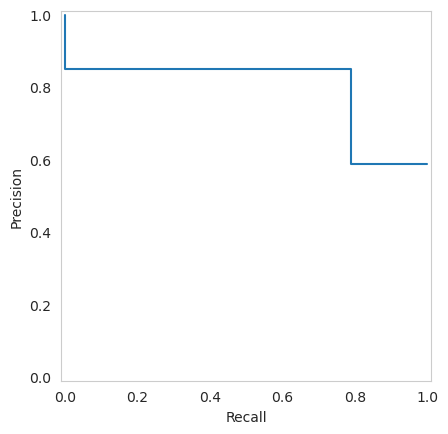

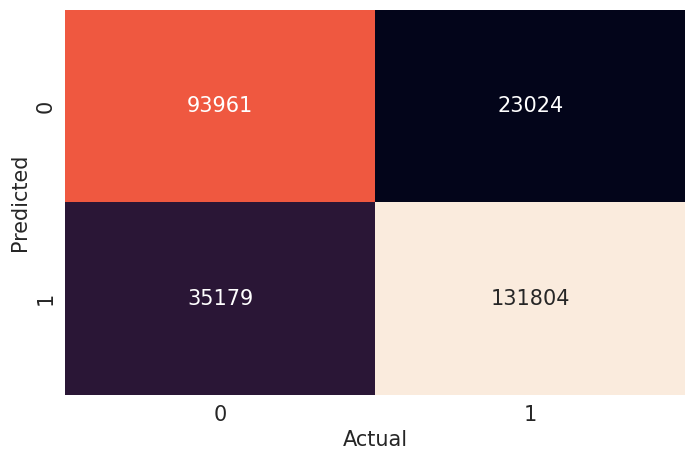

In [15]:
result8020=evaluate(y_test,y_pred)
display_plot(y_test, y_pred)